In [30]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import clean

pd.set_option('display.max_columns', None)

In [3]:
rawdf = pd.read_csv('ames.csv')

In [4]:
# impose uniform snake casing on column names
rawdf.columns = [col.replace(' ', '_').lower() for col in rawdf.columns]

In [5]:
for col in rawdf.columns:
    print(col)

id
pid
ms_subclass
ms_zoning
lot_frontage
lot_area
street
alley
lot_shape
land_contour
utilities
lot_config
land_slope
neighborhood
condition_1
condition_2
bldg_type
house_style
overall_qual
overall_cond
year_built
year_remod/add
roof_style
roof_matl
exterior_1st
exterior_2nd
mas_vnr_type
mas_vnr_area
exter_qual
exter_cond
foundation
bsmt_qual
bsmt_cond
bsmt_exposure
bsmtfin_type_1
bsmtfin_sf_1
bsmtfin_type_2
bsmtfin_sf_2
bsmt_unf_sf
total_bsmt_sf
heating
heating_qc
central_air
electrical
1st_flr_sf
2nd_flr_sf
low_qual_fin_sf
gr_liv_area
bsmt_full_bath
bsmt_half_bath
full_bath
half_bath
bedroom_abvgr
kitchen_abvgr
kitchen_qual
totrms_abvgrd
functional
fireplaces
fireplace_qu
garage_type
garage_yr_blt
garage_finish
garage_cars
garage_area
garage_qual
garage_cond
paved_drive
wood_deck_sf
open_porch_sf
enclosed_porch
3ssn_porch
screen_porch
pool_area
pool_qc
fence
misc_feature
misc_val
mo_sold
yr_sold
sale_type
saleprice


### Deal with Missing Data

#### Columns with NA explained by the data dictionary.

BsmtQual: Height of the basement  
NA No Basement

BsmtCond: General condition of the basement  
NA No Basement

BsmtFinType1: Quality of basement finished area  
NA No Basement

BsmtFinType2: Quality of second finished area (if present)  
NA No Basement

FireplaceQu: Fireplace quality  
NA No Fireplace

GarageType: Garage location  
NA No Garage

GarageFinish: Interior finish of the garage  
NA No Garage

GarageQual: Garage quality  
NA No Garage

GarageCond: Garage condition  
NA No Garage

PoolQC: Pool quality  
NA No Pool

Fence: Fence quality  
NA No Fence

MiscFeature: Miscellaneous feature not covered in other categories  
NA None


### Checking for patterns in missing data.  
Often the same group of variables is missing from an observation.  
This are data that are not missing completely at random.  
It can be the case that None, NaN, and Null.

In [5]:
ng = clean.null_groups(rawdf)
for k,v in ng.items():
    print(k,v)

22 ['mas_vnr_type', 'mas_vnr_area']
55 ['bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1']
2 ['bsmt_full_bath', 'bsmt_half_bath']
114 ['garage_yr_blt', 'garage_finish', 'garage_qual', 'garage_cond']


The basement group with 55 NaN values are all explained by the data dictionary.  
The garage group with 114 NaN values are all explained by the data dictionary, but garage_yr_built must be dropped.  
The garage condition and garage quality ratings capture the value of the garage.  
Must investigate the null values of masonry group and the other basement group.

In [6]:
rawdf['mas_vnr_type'].value_counts(dropna=False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [7]:
rawdf['mas_vnr_area'].value_counts(dropna=False).head()

 0.0      1216
NaN         22
 120.0      11
 200.0      10
 176.0      10
Name: mas_vnr_area, dtype: int64

Masonry column mas_vnr_type contains both None and NaN.  
Masonry column mas_vnr_area contains both None and NaN.  
These rows will need to be dropped or masonry columns will need to be dropped.

In [9]:
# It can be seen that there is contradictory information in the masonry columns.
rawdf[(rawdf['mas_vnr_type']=='None') & (rawdf['mas_vnr_area']!=0)][['mas_vnr_type','mas_vnr_area']]

,mas_vnr_type,mas_vnr_area
765,None,1.0
810,None,288.0
1148,None,1.0
1684,None,1.0
1832,None,344.0


In [14]:
rawdf[rawdf['mas_vnr_area'].isnull()][['mas_vnr_type','mas_vnr_area']]

,mas_vnr_type,mas_vnr_area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


It may be necessary to drop these columns.  
First investigate the correlation with the target.

In [24]:
stats.spearmanr(rawdf['mas_vnr_area'], rawdf['saleprice'], nan_policy='omit')

SpearmanrResult(correlation=0.5106279609089659, pvalue=masked_array(data=3.67431227e-135,
             mask=False,
       fill_value=1e+20))

/home/craig/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:2889: UserWarning: The `dropna` parameter has been removed
  warnings.warn("The `dropna` parameter has been removed", UserWarning)
/home/craig/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


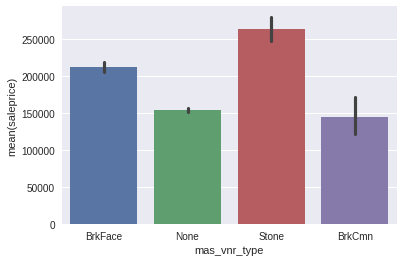

In [32]:
sns.barplot(x='mas_vnr_type', y='saleprice', data=rawdf, dropna=False)

In [41]:
rawdf[rawdf['mas_vnr_type']==np.nan]['saleprice'].count()

0

#### Check the remaining columns with null values explained by the data dictionary. (fireplace, pool, misc, and fence)

In [8]:
rawdf['pool_qc'].value_counts(dropna=False)

NaN    2042
Gd        4
Fa        2
TA        2
Ex        1
Name: pool_qc, dtype: int64

In [9]:
rawdf['pool_area'].value_counts(dropna=False)

0      2042
561       1
519       1
800       1
738       1
648       1
576       1
480       1
368       1
228       1
Name: pool_area, dtype: int64

It can be seen that all pool quality NaN values correspond to pool area = 0.  
Pool quality NaN values indicate no pool.  

In [10]:
# Check to see if there are any observations where
# pool_qc is null and pool_area is not 0
(rawdf['pool_qc'].isnull() & rawdf['pool_area']!=0.0).any() # False

False

The fireplace quality NaN values are all explained by the data dictionary. 

In [11]:
rawdf['fireplace_qu'].value_counts(dropna=False)

NaN    1000
Gd      523
TA      407
Fa       59
Po       31
Ex       31
Name: fireplace_qu, dtype: int64

The fence quality NaN values are all explained by the data dictionary. 

In [12]:
rawdf['fence'].value_counts(dropna=False)

NaN      1651
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: fence, dtype: int64

Miscellaneous Features and Values have explained by the data dictionary NaN values.

In [13]:
rawdf['misc_feature'].value_counts(dropna=False)

NaN     1986
Shed      56
Gar2       4
Othr       3
Elev       1
TenC       1
Name: misc_feature, dtype: int64

In [14]:
(rawdf['misc_feature'].isnull() & rawdf['misc_val']!=0.0).any()

False

In [15]:
rawdf['garage_type'].value_counts(dropna=False)

Attchd     1213
Detchd      536
BuiltIn     132
NaN         113
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64

In [16]:
rawdf[rawdf['garage_type'].notnull() & rawdf['garage_qual'].isnull()]
# conflicting info about garage 6:1 columns say there is no garage  
# impute garage type to NaN 

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [17]:
rawdf['garage_type'][1712] = np.nan

In [18]:
rawdf.isnull().sum()[:10]

id                 0
pid                0
ms_subclass        0
ms_zoning          0
lot_frontage     330
lot_area           0
street             0
alley           1911
lot_shape          0
land_contour       0
dtype: int64

#### Lastly examine Lot Frontage and Alley  

LotFrontage: Linear feet of street connected to property

Alley: Type of alley access to property
Grvl Gravel
Pave Paved
NA No alley access

All alley NaN are explained by the data dictionary.

Lot Frontage NaN seems to be missing at random, is not highly correlated with the target,  
and 16% of values are missing; therefore drop lot_frontage.

In [19]:
rawdf[['lot_frontage', 'saleprice']].dropna(how='any').corr()

,lot_frontage,saleprice
lot_frontage,1.000000,0.341842
saleprice,0.341842,1.000000


In [20]:
rawdf.select_dtypes(exclude='object').isnull().sum()

id                   0
pid                  0
ms_subclass          0
lot_frontage       330
lot_area             0
overall_qual         0
overall_cond         0
year_built           0
year_remod/add       0
mas_vnr_area        22
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
bsmt_full_bath       2
bsmt_half_bath       2
full_bath            0
half_bath            0
bedroom_abvgr        0
kitchen_abvgr        0
totrms_abvgrd        0
fireplaces           0
garage_yr_blt      114
garage_cars          1
garage_area          1
wood_deck_sf         0
open_porch_sf        0
enclosed_porch       0
3ssn_porch           0
screen_porch         0
pool_area            0
misc_val             0
mo_sold              0
yr_sold              0
saleprice            0
dtype: int64

In [21]:
rawdf.select_dtypes(include='object').isnull().sum()

ms_zoning            0
street               0
alley             1911
lot_shape            0
land_contour         0
utilities            0
lot_config           0
land_slope           0
neighborhood         0
condition_1          0
condition_2          0
bldg_type            0
house_style          0
roof_style           0
roof_matl            0
exterior_1st         0
exterior_2nd         0
mas_vnr_type        22
exter_qual           0
exter_cond           0
foundation           0
bsmt_qual           55
bsmt_cond           55
bsmt_exposure       58
bsmtfin_type_1      55
bsmtfin_type_2      56
heating              0
heating_qc           0
central_air          0
electrical           0
kitchen_qual         0
functional           0
fireplace_qu      1000
garage_type        114
garage_finish      114
garage_qual        114
garage_cond        114
paved_drive          0
pool_qc           2042
fence             1651
misc_feature      1986
sale_type            0
dtype: int64

Handle remaining nulls.

In [22]:
mask = (rawdf[[col for col in rawdf.columns if 'bsmt' in col]].isnull().sum(axis=1) > 0)

In [23]:
rawdf[mask][[col for col in rawdf.columns if 'bsmt' in col]]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
12,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
93,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
114,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
146,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
183,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
240,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
249,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
256,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
390,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
437,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


index 616 bsmt_full_bath, bsmt_half_bath impute to 0.0  
  
index 1327 bsmtfin_sf_1, bsmtfin_sf_2, bsmt_unf_sf, total_bsmt_sf, bsmt_full_bath, bsmt_half_bath impute to 0.0

In [24]:
for col in ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']:
    rawdf[col].fillna(0.0, axis=0, inplace=True)

In [25]:
rawdf.loc[[616, 1327], [col for col in rawdf.columns if 'bsmt' in col]]

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
616,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1327,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [26]:
mask = (rawdf[[col for col in rawdf.columns if 'garag' in col]].isnull().sum(axis=1) > 0)
rawdf[mask][[col for col in rawdf.columns if 'garag' in col]]

,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
28,NaN,NaN,NaN,0.0,0.0,NaN,NaN
53,NaN,NaN,NaN,0.0,0.0,NaN,NaN
65,NaN,NaN,NaN,0.0,0.0,NaN,NaN
79,NaN,NaN,NaN,0.0,0.0,NaN,NaN
101,NaN,NaN,NaN,0.0,0.0,NaN,NaN
103,NaN,NaN,NaN,0.0,0.0,NaN,NaN
114,NaN,NaN,NaN,0.0,0.0,NaN,NaN
120,NaN,NaN,NaN,0.0,0.0,NaN,NaN
134,NaN,NaN,NaN,0.0,0.0,NaN,NaN
136,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [27]:
rawdf['garage_area'].fillna(0.0, axis=0, inplace=True)

rawdf['garage_cars'].fillna(0.0, axis=0, inplace=True)

In [28]:
rawdf['mas_vnr_area'].fillna(0.0, axis=0, inplace=True)
      
rawdf['mas_vnr_type'].fillna('None', axis=0, inplace=True)

In [29]:
rawdf.drop('lot_frontage', axis=1, inplace=True)

rawdf.drop('garage_yr_blt', axis=1, inplace=True)

The remaining null values belong to categorical variables, which can be handled as dummies.

In [30]:
df = pd.get_dummies(rawdf, dummy_na=True, drop_first=True)

In [31]:
len(df['id'].unique())

2051

PID is a redundant unique identifier, it will be dropped since it adds no information.

In [32]:
df.drop('pid', axis=1, inplace=True)

In [33]:
df.set_index('id', inplace=True, verify_integrity=True)

This is the new Data Set.

In [34]:
df.to_csv('ames_clean.csv')